# Building Sentiment Analysis model using Supervised Learning w NLP

Data set - Amazon Fine Foods Review from Kaggle

The goal of this project is to predict customer sentiment of Amazon Fine Food Reviews.

In [1]:
# importing necessary modules
%matplotlib inline

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

In [2]:
# load data
df = pd.read_csv("../../../Documents/Reviews.csv", index_col=0)

### EDA

In [3]:
# exploratory data analysis
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.describe()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,1.743817,2.22881,4.183199,1.296257e+09
std,7.636513,8.28974,1.310436,4.804331e+07
min,0.000000,0.00000,1.000000,9.393408e+08
25%,0.000000,0.00000,4.000000,1.271290e+09
50%,0.000000,1.00000,5.000000,1.311120e+09
75%,2.000000,2.00000,5.000000,1.332720e+09
max,866.000000,923.00000,5.000000,1.351210e+09


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568454 entries, 1 to 568454
Data columns (total 9 columns):
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568428 non-null object
Text                      568454 non-null object
dtypes: int64(4), object(5)
memory usage: 43.4+ MB


### Cleaning Data

In [6]:
# dropping missing values since it's not a big number
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568412 entries, 1 to 568454
Data columns (total 9 columns):
ProductId                 568412 non-null object
UserId                    568412 non-null object
ProfileName               568412 non-null object
HelpfulnessNumerator      568412 non-null int64
HelpfulnessDenominator    568412 non-null int64
Score                     568412 non-null int64
Time                      568412 non-null int64
Summary                   568412 non-null object
Text                      568412 non-null object
dtypes: int64(4), object(5)
memory usage: 43.4+ MB


In [7]:
df.Score.value_counts()

5    363111
4     80655
1     52264
3     42639
2     29743
Name: Score, dtype: int64

### Visual EDA

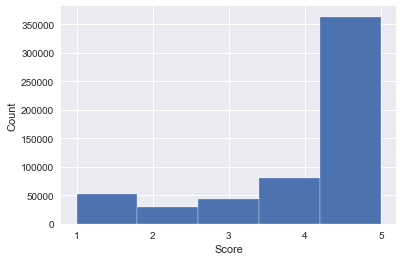

In [8]:
# plot histogram of score distribution
sns.set()
plt.hist(df.Score, bins=5, edgecolor='w')
plt.xticks([1, 2, 3, 4, 5])
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Looks like the reviews are largely skewed towards positive 5 star reviews.

In [9]:
df[df['Score'] == 3].head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
46,B001EO5QW8,A39Z97950MCTQE,K. A. Freel,0,0,3,1205193600,Hearty Oatmeal,This seems a little more wholesome than some o...
48,B001EO5QW8,A26AY1TFK8BQXQ,"kbogo ""shoelover""",1,2,3,1200096000,Mushy,"The flavors are good. However, I do not see a..."
50,B001EO5QW8,A276999Y6VRSCQ,JMay,0,1,3,1334016000,Same stuff,This is the same stuff you can buy at the big ...
54,B000G6RPMY,AQ9DWWYP2KJCQ,"Roel Trevino ""protomex""",0,0,3,1278028800,not ass kickin,we're used to spicy foods down here in south t...
61,B004N5KULM,A1ZR8O62VSU4OK,"Lisa J. Szlosek ""lisa""",2,4,3,1318723200,Better price for this at Target,Watch your prices with this. While the assort...


In [10]:
# creating sentiment column based on scores

def f(row):
    if row['Score'] == 1 or row['Score'] == 2:
        val = 0 # negative review
    elif row['Score'] == 4 or row['Score'] == 5:
        val = 1 # positive review
    else:
        val = None # mixed review
    return val

df['sentiment'] = df.apply(f, axis=1)
df.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
Id,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0.0
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0.0
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1.0


I'm created a new column called *sentiment* to have two classes:

0: negative review
 
1: positive review

In [11]:
df.sentiment.value_counts()

1.0    443766
0.0     82007
Name: sentiment, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568412 entries, 1 to 568454
Data columns (total 10 columns):
ProductId                 568412 non-null object
UserId                    568412 non-null object
ProfileName               568412 non-null object
HelpfulnessNumerator      568412 non-null int64
HelpfulnessDenominator    568412 non-null int64
Score                     568412 non-null int64
Time                      568412 non-null int64
Summary                   568412 non-null object
Text                      568412 non-null object
sentiment                 525773 non-null float64
dtypes: float64(1), int64(4), object(5)
memory usage: 47.7+ MB


In [13]:
filtered_df = df[df['sentiment'].notnull()]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525773 entries, 1 to 568454
Data columns (total 10 columns):
ProductId                 525773 non-null object
UserId                    525773 non-null object
ProfileName               525773 non-null object
HelpfulnessNumerator      525773 non-null int64
HelpfulnessDenominator    525773 non-null int64
Score                     525773 non-null int64
Time                      525773 non-null int64
Summary                   525773 non-null object
Text                      525773 non-null object
sentiment                 525773 non-null float64
dtypes: float64(1), int64(4), object(5)
memory usage: 44.1+ MB


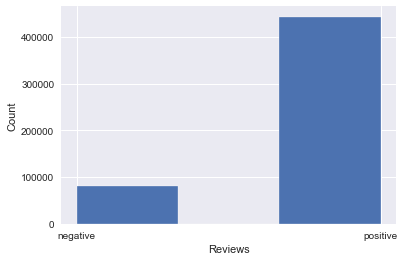

In [14]:
# plotting histogram of the new class of reviews
plt.hist(filtered_df.sentiment, bins=3, edgecolor='w')
plt.xticks([0, 1], ['negative', 'positive'])
plt.xlabel('Reviews')
plt.ylabel('Count')
plt.show()

### CountVectorizer and Multinomial NB

Using *Summary* column as our text data.

In [15]:
# Create a series to store the labels: X, y
y = filtered_df.sentiment
X = filtered_df['Summary']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

# Print the first 10 features of the count_vectorizer
# print(count_vectorizer.get_feature_names()[:10])

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print("Accuracy on test data: %0.2f" % score)

# classification report
print(classification_report(y_test, pred))

Accuracy on test data: 0.91
             precision    recall  f1-score   support

        0.0       0.78      0.58      0.67     27017
        1.0       0.93      0.97      0.95    146489

avg / total       0.90      0.91      0.90    173506



### TfidfVectorizer and Multinomial NB

In [16]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 10 features
#print(tfidf_vectorizer.get_feature_names()[:10])

# Print the first 5 vectors of the tfidf training data
#print(tfidf_train.A[:5])

# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print("Accuracy on test data: %0.2f" % score)

# classification report
print(classification_report(y_test, pred))

Accuracy on test data: 0.91
             precision    recall  f1-score   support

        0.0       0.88      0.46      0.61     27017
        1.0       0.91      0.99      0.95    146489

avg / total       0.90      0.91      0.89    173506



### Improving the model

In [17]:
# Create the list of alphas: alphas
alphas = np.arange(0, 1, 0.1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()


Alpha:  0.0
Score:  0.908320173366

Alpha:  0.1


/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.908735144606

Alpha:  0.2
Score:  0.908775489032

Alpha:  0.3
Score:  0.908452733623

Alpha:  0.4
Score:  0.908153032172

Alpha:  0.5
Score:  0.90765160859

Alpha:  0.6
Score:  0.90691964543

Alpha:  0.7
Score:  0.906383640912

Alpha:  0.8
Score:  0.90608970295

Alpha:  0.9
Score:  0.906677578873



### Logistic Regression with CountVectorizer

In [18]:
# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(count_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = logreg.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, y_pred)
print("Accuracy on test data: %0.2f" % score)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on test data: 0.92
[[ 15615  11402]
 [  3335 143154]]
             precision    recall  f1-score   support

        0.0       0.82      0.58      0.68     27017
        1.0       0.93      0.98      0.95    146489

avg / total       0.91      0.92      0.91    173506



### Random Forest Classifier w CountVectorizer

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Create the classifier
clf = RandomForestClassifier()

# Fit the classifier
clf.fit(count_train,y_train)

# Predict the labels of the test set: y_pred
y_pred = clf.predict(count_test)

# print accuracy score
accuracy = clf.score(count_test,y_test)
print("Random Forest accuracy:",accuracy)

# print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Random Forest accuracy: 0.925126508593
[[ 20018   6999]
 [  5992 140497]]
             precision    recall  f1-score   support

        0.0       0.77      0.74      0.76     27017
        1.0       0.95      0.96      0.96    146489

avg / total       0.92      0.93      0.92    173506



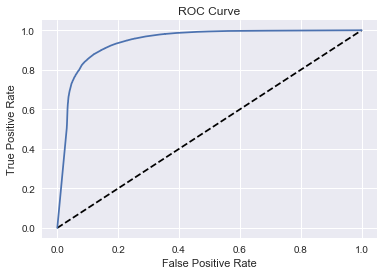

In [20]:
# Import necessary modules
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(count_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [21]:
# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

AUC: 0.9426208282096871


In conclusion, the best classifier is the Random Forest with CountVectorizer which achieves the highest recall and precision scores. The model achieves accuracy score of 92%, f1-score of 93% (f-1 score of 76% for the minority class) and AUC score of 94% which is pretty good.

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words).

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [29]:
words = np.array(count_vectorizer.get_feature_names())
x = np.eye(count_test.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     ")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t      ")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:623: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


Good words	     
           sunflower 1.00
             camping 1.00
               crack 1.00
               grown 1.00
             theater 1.00
             growing 1.00
                cody 1.00
           practical 1.00
                grow 1.00
         jawbreakers 1.00
Bad words	      
                yuck 0.00
                yuch 0.00
                flat 0.00
          yuccchhhhh 0.00
     blaaaaaaannnnnd 0.00
          flavorless 0.00
               flaws 0.00
               pikes 0.00
              flimsy 0.00
              failed 0.00
